In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
df = pd.read_csv('/content/Musical_instruments_reviews.csv', engine='python', on_bad_lines='warn')

In [3]:
df.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [4]:
print(f"Dataset shape: {df.shape}")

Dataset shape: (10261, 9)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10254 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB


In [6]:
df.isnull().sum()

,0
reviewerID,0
asin,0
reviewerName,27
helpful,0
reviewText,7
overall,0
summary,0
unixReviewTime,0
reviewTime,0


In [7]:
df.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

/tmp/ipython-input-201165157.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='overall', data=df, palette='viridis')


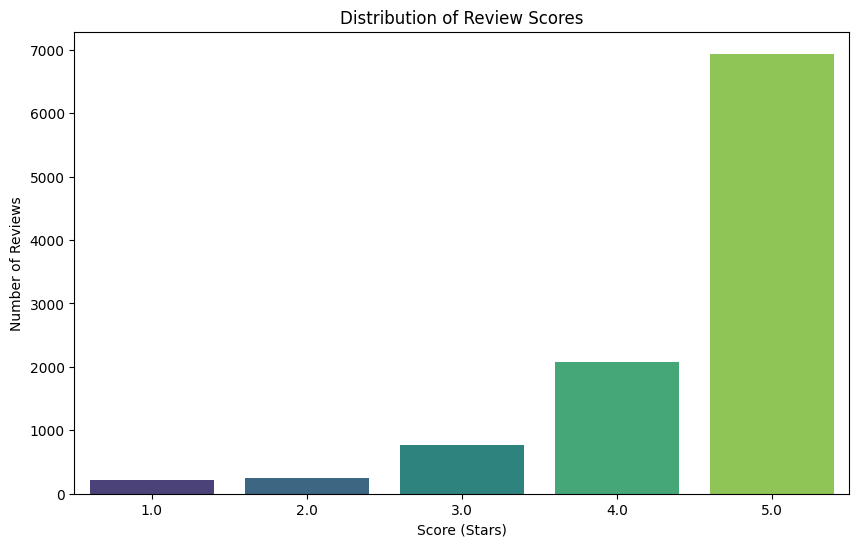

In [8]:
#Analyze the distribution of scores
plt.figure(figsize=(10, 6))
sns.countplot(x='overall', data=df, palette='viridis')
plt.title('Distribution of Review Scores')
plt.xlabel('Score (Stars)')
plt.ylabel('Number of Reviews')
plt.show()

In [9]:
# Check the value counts
print(df['overall'].value_counts())

overall
5.0    6938
4.0    2084
3.0     772
2.0     250
1.0     217
Name: count, dtype: int64


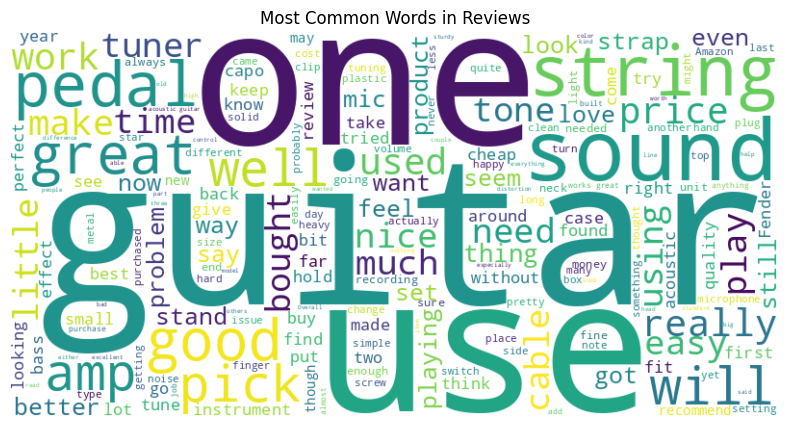

In [10]:
# Word cloud of reviews
from wordcloud import WordCloud

text = ' '.join(df['reviewText'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Reviews")
plt.show()

In [11]:
#Text Preprocessing

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()
    # 2. Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # 3. Remove URLs and non-alphanumeric characters
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    # 4. Tokenize and remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    # 5. Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

In [12]:
# Applying preprocessing to the 'reviewText' column
df['Processed_Text'] = df['reviewText'].fillna('').apply(preprocess_text)

In [13]:
#Example of original vs. processed text
df[['reviewText', 'Processed_Text']].head(5)

,reviewText,Processed_Text
0,"Not much to write about here, but it does exac...",much write exactly supposed filter pop sound r...
1,The product does exactly as it should and is q...,product exactly quite affordablei realized dou...
2,The primary job of this device is to block the...,primary job device block breath would otherwis...
3,Nice windscreen protects my MXL mic and preven...,nice windscreen protects mxl mic prevents pop ...
4,This pop filter is great. It looks and perform...,pop filter great look performs like studio fil...


In [14]:
#Defining Features (X) and Target (y)
X = df['Processed_Text']
y = df['overall']

In [15]:
#Spliting data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
# stratify=y to ensure the class distribution is the same in train and test sets

In [16]:
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 8208
Test set size: 2053


In [17]:
#Model 1: Logistic Regression Pipeline

lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1, 2))),
    ('clf', LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced'))
])

lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=20000, ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(class_weight='balanced', random_state=42,
                                    solver='liblinear'))])

In [18]:
#Model 2: Support Vector Classifier (SVC) Pipeline

svc_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1, 2))),
    ('clf', SVC(random_state=42, kernel='linear', class_weight='balanced'))
])

svc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=20000, ngram_range=(1, 2))),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear',
                     random_state=42))])

In [19]:
def evaluate_model(pipeline, model_name):
    print(f"\nEvaluating {model_name}")
    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual Score')
    plt.xlabel('Predicted Score')
    plt.show()


Evaluating Logistic Regression
Accuracy: 0.6790

Classification Report:
              precision    recall  f1-score   support

         1.0       0.38      0.19      0.25        43
         2.0       0.10      0.04      0.06        50
         3.0       0.26      0.15      0.20       155
         4.0       0.39      0.20      0.26       417
         5.0       0.75      0.92      0.82      1388

    accuracy                           0.68      2053
   macro avg       0.38      0.30      0.32      2053
weighted avg       0.62      0.68      0.63      2053



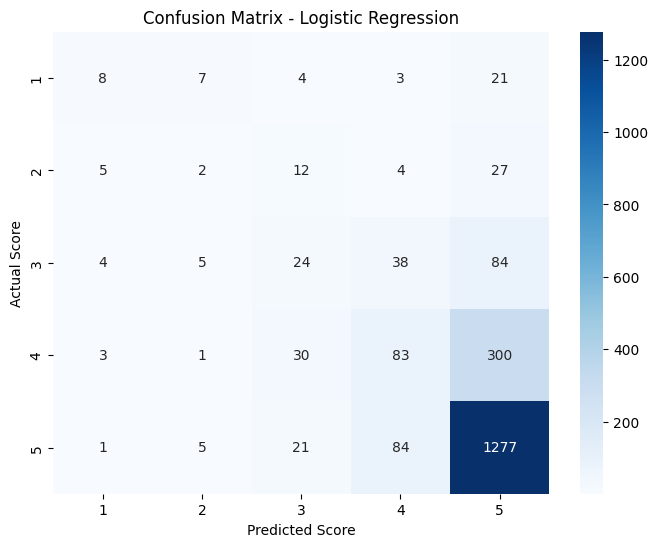


Evaluating Support Vector Classifier
Accuracy: 0.6074

Classification Report:
              precision    recall  f1-score   support

         1.0       0.42      0.19      0.26        43
         2.0       0.14      0.06      0.08        50
         3.0       0.23      0.29      0.26       155
         4.0       0.32      0.47      0.38       417
         5.0       0.82      0.72      0.77      1388

    accuracy                           0.61      2053
   macro avg       0.39      0.34      0.35      2053
weighted avg       0.65      0.61      0.62      2053



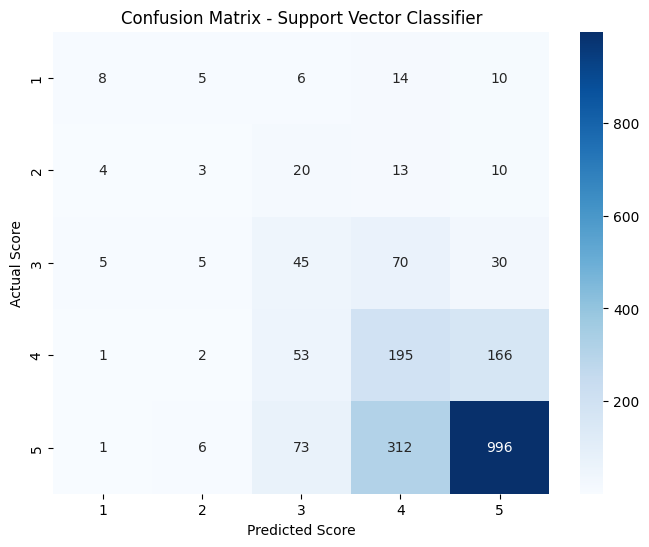

In [20]:
# Evaluating both the models
evaluate_model(lr_pipeline, "Logistic Regression")
evaluate_model(svc_pipeline, "Support Vector Classifier")

In [21]:
# Function to predict sentiment of new reviews
def predict_sentiment(text, model):
    processed_text = preprocess_text(text)
    prediction = model.predict([processed_text])
    prediction_proba = model.predict_proba([processed_text]) # Get probabilities

    # Get the highest probability
    max_proba = np.max(prediction_proba)

    print(f"\nReview: '{text}'")
    print(f"Predicted Score: {prediction[0]} Stars")
    print(f"Confidence: {max_proba:.2f}")

In [22]:
# Using the trained LR pipeline for prediction
new_review_1 = "This is the best product I have ever bought. Absolutely fantastic!"
new_review_2 = "It was an okay product. Did the job but nothing to be excited about."
new_review_3 = "Complete waste of money. Broke after one use. Terrible quality."

predict_sentiment(new_review_1, lr_pipeline)
predict_sentiment(new_review_2, lr_pipeline)
predict_sentiment(new_review_3, lr_pipeline)


Review: 'This is the best product I have ever bought. Absolutely fantastic!'
Predicted Score: 5.0 Stars
Confidence: 0.76

Review: 'It was an okay product. Did the job but nothing to be excited about.'
Predicted Score: 3.0 Stars
Confidence: 0.44

Review: 'Complete waste of money. Broke after one use. Terrible quality.'
Predicted Score: 1.0 Stars
Confidence: 0.38


In [23]:
!pip install transformers torch

In [24]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Predicting same reviews using the BERT model
result1 = classifier(new_review_1)
result2 = classifier(new_review_2)
result3 = classifier(new_review_3)

print(f"Review: '{new_review_1}'")
print(f"BERT Prediction: {result1}")

print(f"\nReview: '{new_review_2}'")
print(f"BERT Prediction: {result2}")

print(f"\nReview: '{new_review_3}'")
print(f"BERT Prediction: {result3}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


Review: 'This is the best product I have ever bought. Absolutely fantastic!'
BERT Prediction: [{'label': '5 stars', 'score': 0.9880610704421997}]

Review: 'It was an okay product. Did the job but nothing to be excited about.'
BERT Prediction: [{'label': '3 stars', 'score': 0.8460391759872437}]

Review: 'Complete waste of money. Broke after one use. Terrible quality.'
BERT Prediction: [{'label': '1 star', 'score': 0.9714365601539612}]
